In [7]:
%pylab inline
import pandas as pd
import seaborn as sns


Populating the interactive namespace from numpy and matplotlib


In [20]:
!ls | grep pkl

merged.pkl
movie_urls.pkl
series_deltas.pkl


In [149]:
df = pd.read_pickle('merged.pkl')

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 621 entries, 0 to 632
Data columns (total 19 columns):
title           621 non-null object
stars           621 non-null object
critics         509 non-null float64
genres          621 non-null object
rating          617 non-null object
year            621 non-null object
budget          621 non-null float64
scope           618 non-null object
total_gross     621 non-null float64
release_date    619 non-null datetime64[ns]
runtime         617 non-null float64
series_id       621 non-null float64
part            621 non-null float64
ROI             621 non-null float64
masses          617 non-null float64
delta           394 non-null timedelta64[ns]
ROI_delta       396 non-null float64
budget_delta    396 non-null float64
rt_delta        391 non-null timedelta64[ns]
dtypes: datetime64[ns](1), float64(10), object(6), timedelta64[ns](2)
memory usage: 97.0+ KB


In [151]:
# Remove the first item of each sequel
df = df[df.part > 1]

# Initial Graphs

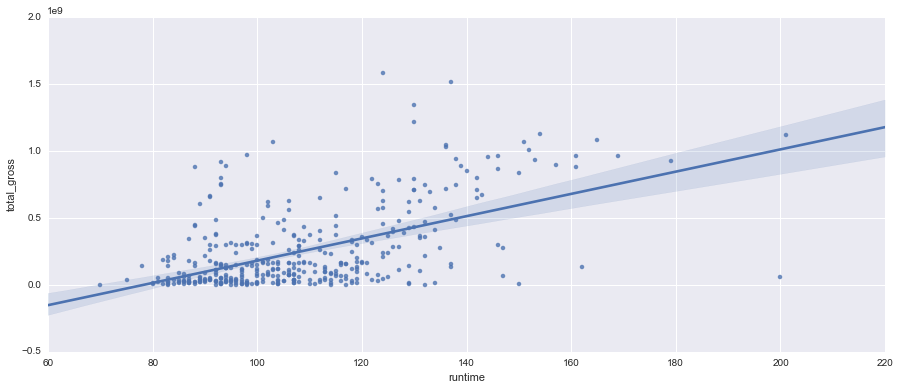

In [152]:
plt.figure(figsize=(15,6));
sns.regplot('runtime', 'total_gross', data=df);

In [153]:
df.columns

Index(['title', 'stars', 'critics', 'genres', 'rating', 'year', 'budget',
       'scope', 'total_gross', 'release_date', 'runtime', 'series_id', 'part',
       'ROI', 'masses', 'delta', 'ROI_delta', 'budget_delta', 'rt_delta'],
      dtype='object')

In [154]:
num_cols = ['budget', 'total_gross', 'runtime', 'masses', 'critics', 'estimated_roi',
           'thumb_rule_roi']

In [257]:
df[num_cols].describe().to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>budget</th>\n      <th>total_gross</th>\n      <th>runtime</th>\n      <th>masses</th>\n      <th>critics</th>\n      <th>estimated_roi</th>\n      <th>thumb_rule_roi</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>count</th>\n      <td>3.940000e+02</td>\n      <td>3.940000e+02</td>\n      <td>392.000000</td>\n      <td>392.000000</td>\n      <td>311.000000</td>\n      <td>394.000000</td>\n      <td>394.000000</td>\n    </tr>\n    <tr>\n      <th>mean</th>\n      <td>6.231128e+07</td>\n      <td>2.502957e+08</td>\n      <td>108.346939</td>\n      <td>6.117857</td>\n      <td>0.503987</td>\n      <td>1.129540</td>\n      <td>2.780982</td>\n    </tr>\n    <tr>\n      <th>std</th>\n      <td>6.121265e+07</td>\n      <td>2.989594e+08</td>\n      <td>19.705817</td>\n      <td>1.140170</td>\n      <td>0.167821</td>\n      <td>3.263206</td>\n      <td>5.933102</td>\n  

# Defining a good Metric of ROI

Conventional wisdom is that a firm needs to make twice their production budget in order to break even (achieve a 0% ROI). This rule of thumb, however, has been around for decades and may no longer be accurate due to rising marketing costs. In 1980, average marketing costs were $12.4MM in 2015 dollars. Today it is at 40MM. The biggest cost is TV advertising.  Below is a table of market costs for various movies. 

Movie | Year | Cost | Produciton BG
-- | -- | -- | --
Average | 1980 | 12.4MM |
Average | 2015 | 40MM |
Average | 2007 | 36 MM |70MM
Transformers 1 | 2007 | 150 MM | 147 MM
Transformers 4 | 2014 | 200MM | 210MM

In additional to marketing costs, studios share about 45% of their revenues with movie theatres.

Given this data, I estimate ROIs using the following formulas:

$$ estimated\_roi = \frac{Gross * .55 - Production\_Budget * 1.5}{Production\_Budget} $$

I multiply the production budget by 1.5 to account for the fact that marketing costs about as much as 50% of the production budget, on average. Gross is multiplide by .55 to reflect that studios give 45% of revenues to the movie threatres.

$$ thumb\_rule\_ROI = \frac{Gross - Production\_Budget * 2}{Production\_Budget} $$

In [156]:
estimated_roi = (df.total_gross * .55 - df.budget * 1.5) / df.budget
thumb_rule_roi = (df.total_gross - df.budget * 2) / df.budget
naive_roi = df.total_gross / df.budget

In [157]:
naive_roi.mean(), thumb_rule_roi.mean(), estimated_roi.mean()

(4.7809822155272386, 2.780982215527239, 1.1295402185399814)

The degree to which the rule of thumb roi diverges from my estimated roi is staggering. According to the rule of thumb, sequels are earning a 137% return on investment. When estimating the ROI directly, we see that the ROI is only about 110%. 

If anything my estimated ROI is optimistic. My marketing budget is based off of proportions obsreved in 2007. Since then, marketing [expenses have skyrocketed](http://www.hollywoodreporter.com/news/200-million-rising-hollywood-struggles-721818).

In [158]:
df['estimated_roi'] = estimated_roi
df['thumb_rule_roi'] = thumb_rule_roi

# More Descriptive Statistics

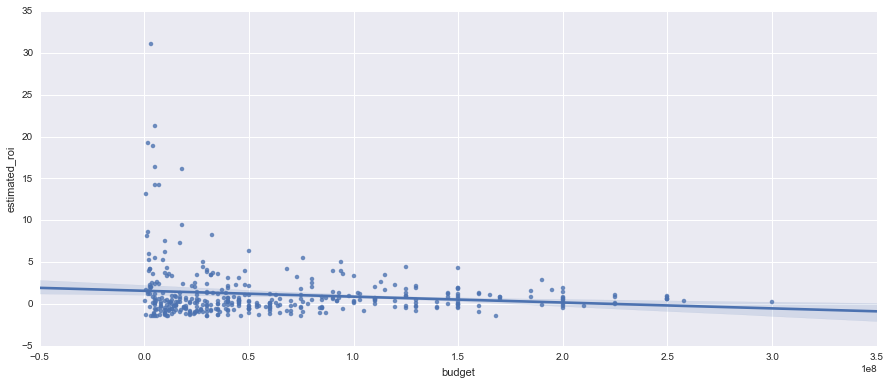

In [71]:
plt.figure(figsize=(15,6));
sns.regplot('budget', 'estimated_roi', data=df);

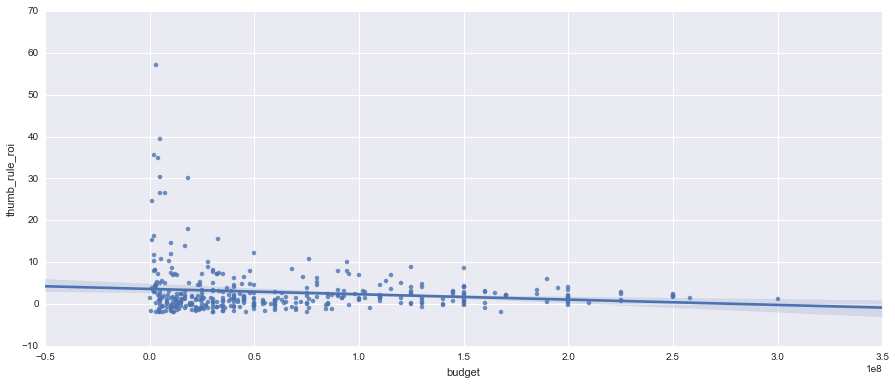

In [73]:
plt.figure(figsize=(15,6));
sns.regplot('budget', 'thumb_rule_roi', data=df);

In [74]:
len(df[df.estimated_roi < -1])

37

There are 39 movies in our dataset that managed to lose more than their entire production budget.

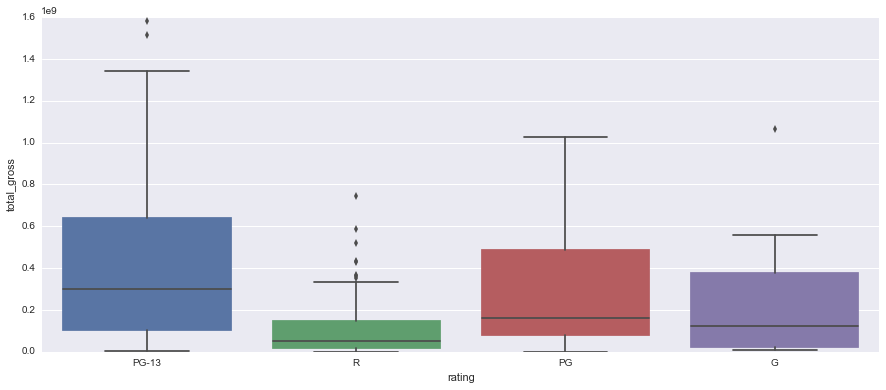

In [75]:
plt.figure(figsize=(15,6));
sns.boxplot(x='rating', y='total_gross', data=df);

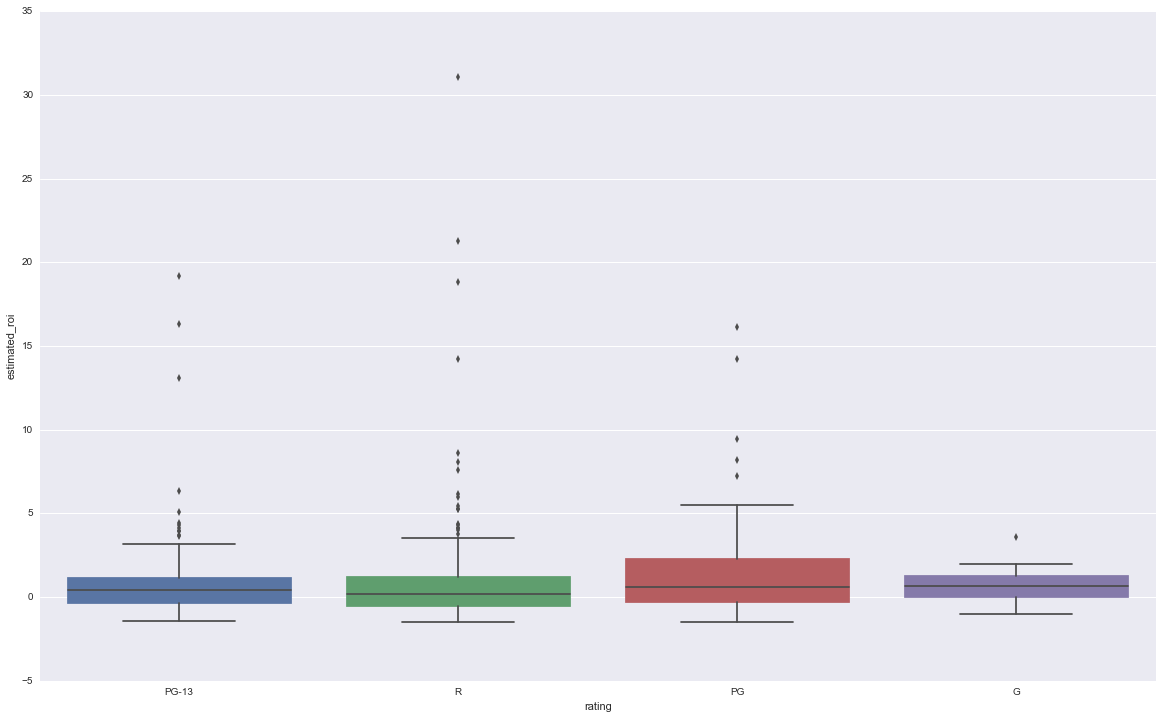

In [81]:
plt.figure(figsize=(20,12));
sns.boxplot(x='rating', y='estimated_roi', data=df);
# sns.stripplot('rating', 'estimated_roi', data=df);

In [192]:
df.groupby('rating').estimated_roi.mean()

rating
G        0.747900
PG       1.626363
PG-13    0.917033
R        1.132656
Name: estimated_roi, dtype: float64

Here we can see that ROIs that are negative are quite common for every single genre. 

# Building our Model

## Steps

1. Make the dmatrices model

In [189]:
df.head(2)

,title,stars,critics,genres,rating,year,budget,scope,total_gross,release_date,...,part,ROI,masses,delta,ROI_delta,budget_delta,rt_delta,estimated_roi,thumb_rule_roi,month
1,Spider-Man 2,"[Tobey Maguire, Kirsten Dunst, Alfred Molina, ...",0.83,"[Action, Adventure, Fantasy]",PG-13,2004,200000000,World,783766341,2004-06-30,...,2,3.918832,7.3,789,-1.992741,61000000,00:06:00,0.655357,1.918832,6
2,Spider-Man 3,"[Tobey Maguire, Kirsten Dunst, Topher Grace, T...",0.59,"[Action, Adventure]",PG-13,2007,258000000,World,890871626,2007-05-04,...,3,3.452991,6.2,1038,-0.465841,58000000,00:12:00,0.399145,1.452991,5


In [164]:
df.delta = df.delta.apply(lambda x: x / np.timedelta64(1, 'D'))

In [161]:
df['month'] = pd.DatetimeIndex(df.release_date).month

In [142]:
from patsy import dmatrices

In [143]:
#  masses:critis

SyntaxError: invalid syntax (<ipython-input-143-1aa16e356609>, line 1)

In [234]:
y, X = dmatrices('thumb_rule_roi ~ C(rating) + np.log(budget)'
                 '+ delta + np.log(masses) + critics + C(month) +'
                'runtime', data=df)

In [195]:
from sklearn import linear_model

In [196]:
clf = linear_model.Lasso(alpha=0.2)
fit = clf.fit(X,y)

In [198]:
fit.coef_

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -1.07069246e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         1.57720283e+00,   0.00000000e+00,  -0.00000000e+00,
        -2.14063333e+00,  -4.56765202e-04,   1.08534870e+00,
         0.00000000e+00,   4.05086676e-03])

In [114]:
import statsmodels.formula.api as smf

In [116]:
from statsmodels import OLS

ImportError: cannot import name 'OLS'

In [120]:
import statsmodels.regression.linear_model as linear_model

In [123]:
import statsmodels.api as sm

In [204]:
from statsmodels.regression.linear_model import OLS

In [ ]:
OLS.fi

In [129]:
df.critics.values[0]

'83/100'

In [211]:
model = OLS(y, X).fit_regularized(alpha=0.1)

In [213]:
df.month

1       6
2       5
4       5
5      11
7      12
8      12
10     11
11      5
13      7
14      5
15      7
17      7
18      5
19      6
20      2
22      5
23      7
25      6
26      5
27     11
28     11
29     12
31      5
32      5
33      1
35      7
36      7
37      5
39      6
40     11
       ..
580     9
582     2
584     4
586    11
588     6
589    11
591    10
592     3
594    12
596     2
599     5
601    11
602     8
603    10
604    11
606     3
607     4
609     5
612     3
614    11
616     6
618     5
619     6
621     9
623     7
625     4
627    10
629    12
630    12
632    10
Name: month, dtype: int32

In [ ]:
df[df.month.isin([])]

In [227]:
df = df.drop('index', axis=1)

In [228]:
df.loc[(df.month == 10) & (df.estimated_roi > 10)]

,title,stars,critics,genres,rating,year,budget,scope,total_gross,release_date,...,part,ROI,masses,delta,ROI_delta,budget_delta,rt_delta,estimated_roi,thumb_rule_roi,month
55,Saw II,"[Donnie Wahlberg, Beverley Mitchell, Franky G,...",0.40,[Horror],R,2005,4000000,World,147748505,2005-10-28,...,2,36.937126,6.6,364,-49.655931,2800000,-1 days +23:50:00,18.815419,34.937126,10
291,Paranormal Activity 2,"[Katie Featherston, Micah Sloat, Molly Ephraim...",0.53,[Horror],R,2010,3000000,World,177512032,2010-10-22,...,2,59.170677,5.7,371,-12831.215989,2985000,00:05:00,31.043873,57.170677,10
292,Paranormal Activity 3,"[Chloe Csengery, Jessica Tyler Brown, Christop...",0.59,[Horror],R,2011,5000000,World,207039844,2011-10-21,...,3,41.407969,5.9,364,-17.762709,2000000,-1 days +23:52:00,21.274383,39.407969,10
293,Paranormal Activity 4,"[Stephen Dunham, Katie Featherston, Matt Shive...",0.40,[Horror],R,2012,5000000,World,142838957,2012-10-19,...,4,28.567791,4.6,364,-12.840177,0,00:05:00,14.212285,26.567791,10


In [223]:
df = df.reset_index()

In [229]:
df_no_paranormal = df.drop(df.index[[291,292,293]])

In [237]:
model = OLS(y, X).fit_regularized(alpha=0.1)

In [240]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         thumb_rule_roi   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2.881
Date:                Thu, 08 Oct 2015   Prob (F-statistic):           7.63e-05
Time:                        15:58:42   Log-Likelihood:                -975.95
No. Observations:                 310   AIC:                             1992.
Df Residuals:                     290   BIC:                             2067.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept                   0          0        nan        nan             0         0
C(rating)[T.PG]        0.0452      0.932      0.048      0.961        -1.790     1.880
C(rating)[T.PG-13]          0          0        nan        nan             0         0
C(rating)[T.R]        -0.0198      0.757     -0.026      0.979        -1.511     1.471
C(month)[T.2]               0          0        nan        nan             0         0
C(month)[T.3]               0          0        nan        nan             0         0
C(month)[T.4]               0          0        nan        nan             0         0
C(month)[T.5]               0          0        nan        nan             0         0
C(month)[T.6]               0          0        nan        nan             0         0
C(month)[T.7]               0          0        nan        nan             0         0
C(month)[T.8]               0          0        nan        nan             0         0
C(month)[T.9]               0          0        nan        nan             0         0
C(month)[T.10]         4.9611      1.303      3.806      0.000         2.396     7.527
C(month)[T.11]              0          0        nan        nan             0         0
C(month)[T.12]              0          0        nan        nan             0         0
np.log(budget)        -0.5198      0.179     -2.906      0.004        -0.872    -0.168
delta                 -0.0004      0.000     -1.726      0.085        -0.001  5.52e-05
np.log(masses)         6.3473      1.856      3.420      0.001         2.694    10.000
critics                     0          0        nan        nan             0         0
runtime                0.0064      0.020      0.321      0.749        -0.033     0.045
==============================================================================
Omnibus:                      313.800   Durbin-Watson:                   1.386
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9903.108
Skew:                           4.300   Prob(JB):                         0.00
Kurtosis:                      29.320   Cond. No.                     5.31e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1]:
plt.figure(figsize=(15,6));
plt.ylim(-5,40)
sns.regplot(y='thumb_rule_roi', x='masses', data=df)

NameError: name 'sns' is not defined

In [241]:
results = model.summary()

In [244]:
results = results.tables[1]

In [245]:
type(results)

statsmodels.iolib.table.SimpleTable

In [251]:
df.columns

Index(['title', 'stars', 'critics', 'genres', 'rating', 'year', 'budget',
       'scope', 'total_gross', 'release_date', 'runtime', 'series_id', 'part',
       'ROI', 'masses', 'delta', 'ROI_delta', 'budget_delta', 'rt_delta',
       'estimated_roi', 'thumb_rule_roi', 'month'],
      dtype='object')